In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


2.load the test and train data

In [52]:
train=pd.read_csv('train_dataset.csv')

In [53]:
test=pd.read_csv('test_dataset.csv')

In [54]:
x_train,y_train,x_test,y_test=train.drop("fraud_bool",axis=1),train["fraud_bool"],test.drop("fraud_bool",axis=1),test["fraud_bool"]

In [55]:
x_train.shape

(800000, 28)

Apply Smote to the data

In [56]:
y_train.shape

(800000,)

In [57]:
smote=SMOTE(random_state=42)
x_res,y_res=smote.fit_resample(x_train,y_train)

In [58]:
print("Original dataset shape",np.bincount(y_train))
print("Dataset after SMOTE",np.bincount(y_res))

Original dataset shape [791177   8823]
Dataset after SMOTE [791177 791177]


4. train XGboost

In [59]:
pos_weight=(y_train==0).sum()/(y_train==1).sum()

In [60]:
model=XGBClassifier(
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42,
)
model.fit(x_res,y_res)

C:\Users\anubhav goyal\PyCharmMiscProject\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:32:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

5.predict the model

In [61]:
y_proba=model.predict_proba(x_test)[:, 1]
y_pred=model.predict(x_test)

In [62]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[164151  33643]
 [   526   1680]]


In [83]:
precision,recall,thresholds=precision_recall_curve(y_test,y_proba)
f1_scores=2*(precision*recall)/(precision+recall+1e-08)

In [85]:
best_threshold=thresholds[np.argmax(f1_scores)]
print("Best threshold",best_threshold)

Best threshold 0.95842355


plotting the f1 vs threshold graph

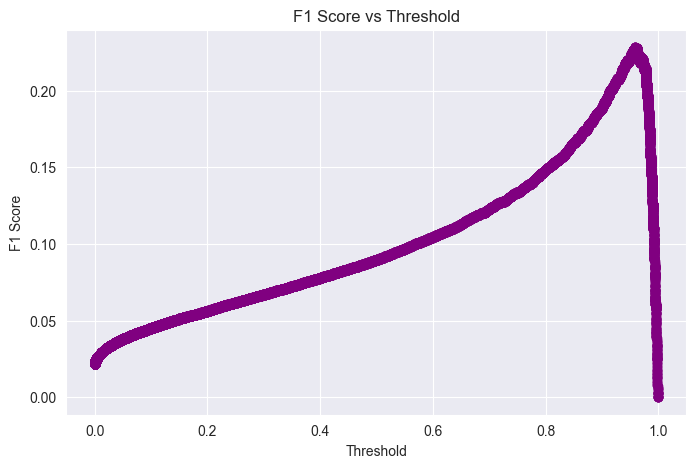

In [86]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], marker='o', color='purple')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid(True)
plt.show()


7. predicting the optimal threshold

In [87]:
y_pred=(y_proba>best_threshold)*1

In [89]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    197794
           1       0.20      0.27      0.23      2206

    accuracy                           0.98    200000
   macro avg       0.60      0.63      0.61    200000
weighted avg       0.98      0.98      0.98    200000



In [90]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[195407   2387]
 [  1615    591]]


8. Top-N fraud ranking

In [91]:
df_pred = pd.DataFrame({'Actual': y_test, 'Fraud_Probability': y_proba})
df_pred['Predicted'] = y_pred
df_pred_sorted = df_pred.sort_values(by='Fraud_Probability', ascending=False)


In [92]:
top_n = int(len(df_pred_sorted) * 0.05)
df_top5 = df_pred_sorted.head(top_n)


In [93]:
print("\nTop 5% Threshold Fraud Detection Performance:")
print(confusion_matrix(df_top5['Actual'], df_top5['Predicted']))
print(classification_report(df_top5['Actual'], df_top5['Predicted'], digits=4))


Top 5% Threshold Fraud Detection Performance:
[[6560 2387]
 [ 462  591]]
              precision    recall  f1-score   support

           0     0.9342    0.7332    0.8216      8947
           1     0.1985    0.5613    0.2932      1053

    accuracy                         0.7151     10000
   macro avg     0.5663    0.6472    0.5574     10000
weighted avg     0.8567    0.7151    0.7660     10000



Before applying the threshold tuning techniuq it have high recall value but after bset tuning  it have high accuracy rather then recall values.
It is all my best which can i predict

In my next notebook I might able to resolve these.